# Customer Personality Analysis: Clustering
## Importing libraries

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
from itertools import product

pd.set_option('display.max_columns', None)

## Loading data

In [148]:
original_df = pd.read_csv('../data/marketing_campaign.csv', sep='\t')
print(f'Number of datapoints: {len(original_df)}')
original_df.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### About the dataset
#### Customer's information
- ID
- Year_Birth
- Education
- Marita_Status
- Income
- Kidhome
- Teenhome
- Dt_Customer: Date of customer's enrollment with the company)
- Recency: Number of days since customer's last purchase)
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise)

#### Products (spent in the last 2 years)
- MntWines: Amount spent on wine
- MntFruits: Amount spent on fruits
- MntMeatProducts: Amount spent on meat
- MntFishProducts: Amount spent on fish
- MntSweetProducts: Amount spent on sweets
- MntGoldProds: Amount spent on gold

#### Promotion
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

#### Place
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

## Data Cleaning

**Section steps:**
- Data cleaning
- Feature Engineering

First of all, let's take a look about the data distribution

In [149]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

For the previous output, we can conclue:
- There are missing values in income
- Dt_Customer is not a DateTime
- There are some categorical values in some features. We have to encode those values

To begin with, the missing values must be deleted having in mind that their represent a very low amount

In [150]:
df = original_df.dropna()
print(f'We drop {len(original_df) - len(df)} records')

We drop 24 records


Then, let's create a new column to hold the customer enrolment date but relative to the newest value

In [151]:
dates = [i.date() for i in pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')]
print(f'Newest customer\'s enrolment date: {max(dates)}')
print(f'Oldest customer\'s enrolment date: {min(dates)}')

Newest customer's enrolment date: 2014-06-29
Oldest customer's enrolment date: 2012-07-30


I'm going to create column `days_being_customer` to express the days that the customer is being with the company relative to the newest customer

In [152]:
newest_date = max(dates)
df['days_being_customer'] = [newest_date - date for date in dates]
df['days_being_customer'] = df['days_being_customer'].dt.days
df.head()

/tmp/ipykernel_2915/147485637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_being_customer'] = [newest_date - date for date in dates]
/tmp/ipykernel_2915/147485637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_being_customer'] = df['days_being_customer'].dt.days


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,days_being_customer
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,663
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,113
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,312
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,139
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,161


Then, let's convert categorical values to numerical

In [153]:
print(f'Total categories in Marital_Status: {df.Marital_Status.value_counts()}')
print(f'Total categories in Education: {df.Education.value_counts()}')

Total categories in Marital_Status: Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64
Total categories in Education: Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In the next bit, I'll engineer some features:
- Change 'Year_Birth' for the actual `age`
- New column call `spent` indicating the total amount spent across all the items
- Another feature `children` adding teens and kids
- To get further clarity of household, creating feature for `family_size`
- Create new feature for `is_parent`
- Finally, a three categories values in `education`
- Dropping some of the redundant features


In [154]:
df_clean = df.copy()

df_clean['age'] = 2023 - df_clean['Year_Birth']

df_clean['spent'] = df_clean["MntWines"]+ df_clean["MntFruits"]+ df_clean["MntMeatProducts"]+ df_clean["MntFishProducts"]+ df_clean["MntSweetProducts"]+ df_clean["MntGoldProds"]

df_clean['children'] = df_clean['Kidhome'] + df_clean['Teenhome']

df_clean['have_partner'] = df_clean["Marital_Status"].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0, "Alone": 0})

df_clean['family_size'] = df_clean['children'] + df_clean['have_partner'] + 1

df_clean['is_parent'] = np.where(df_clean.children > 0, 1, 0)

df_clean["Education"]= df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

df_clean.rename(columns={
    "MntWines": "wines",
    "MntFruits":"fruits",
    "MntMeatProducts":"meat",
    "MntFishProducts":"fish",
    "MntSweetProducts":"sweets",
    "MntGoldProds":"gold"}
    )

columns_to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df_clean = df_clean.drop(columns_to_drop, axis=1)

After cleaned most of the data, we can take a look about the statistics

In [155]:
df_clean.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,days_being_customer,age,spent,children,have_partner,family_size,is_parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,353.521209,54.179603,607.075361,0.947202,0.645307,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.478528,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,5.000000,0.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,46.000000,69.000000,0.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,355.500000,53.000000,396.500000,1.000000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,529.000000,64.000000,1048.000000,1.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,699.000000,130.000000,2525.000000,3.000000,1.000000,5.000000,1.000000


The describe table show some discrepancies in mean Income and Age and max income and age. Do note that max-age is 130 years. Let's plot some features to review:

<Figure size 432x288 with 0 Axes>

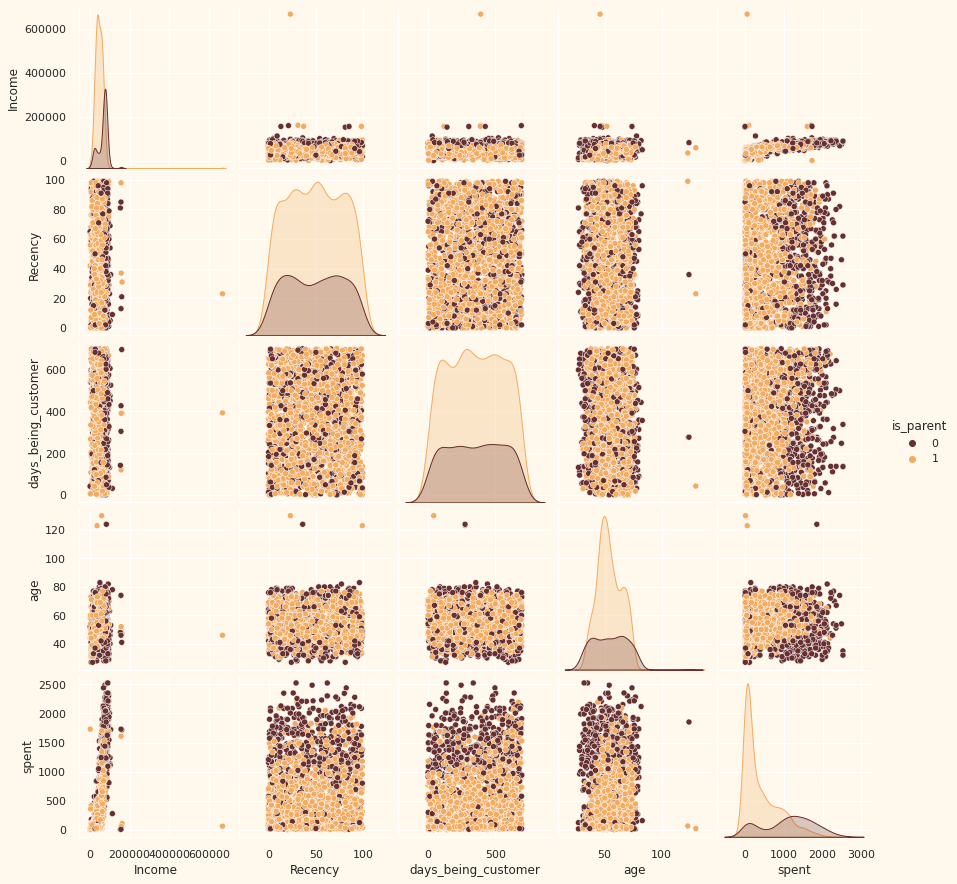

In [156]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
to_plot = ['Income', 'Recency', 'days_being_customer', 'age', 'spent', 'is_parent']

plt.figure()
sns.pairplot(df_clean[to_plot], hue='is_parent', palette= (["#682F2F","#F3AB60"]))
plt.show()

As we suspect, income and age features have outliers. The best approach right now is to delete those rows

In [157]:
df_clean = df_clean[(df_clean.age < 90)]
df_clean = df_clean[(df_clean.Income < 600000)]
print(f'The new row count is {len(df_clean)}')

The new row count is 2212


As final step in the cleaning phase, let us look the correlation amongst the features

<Axes: >

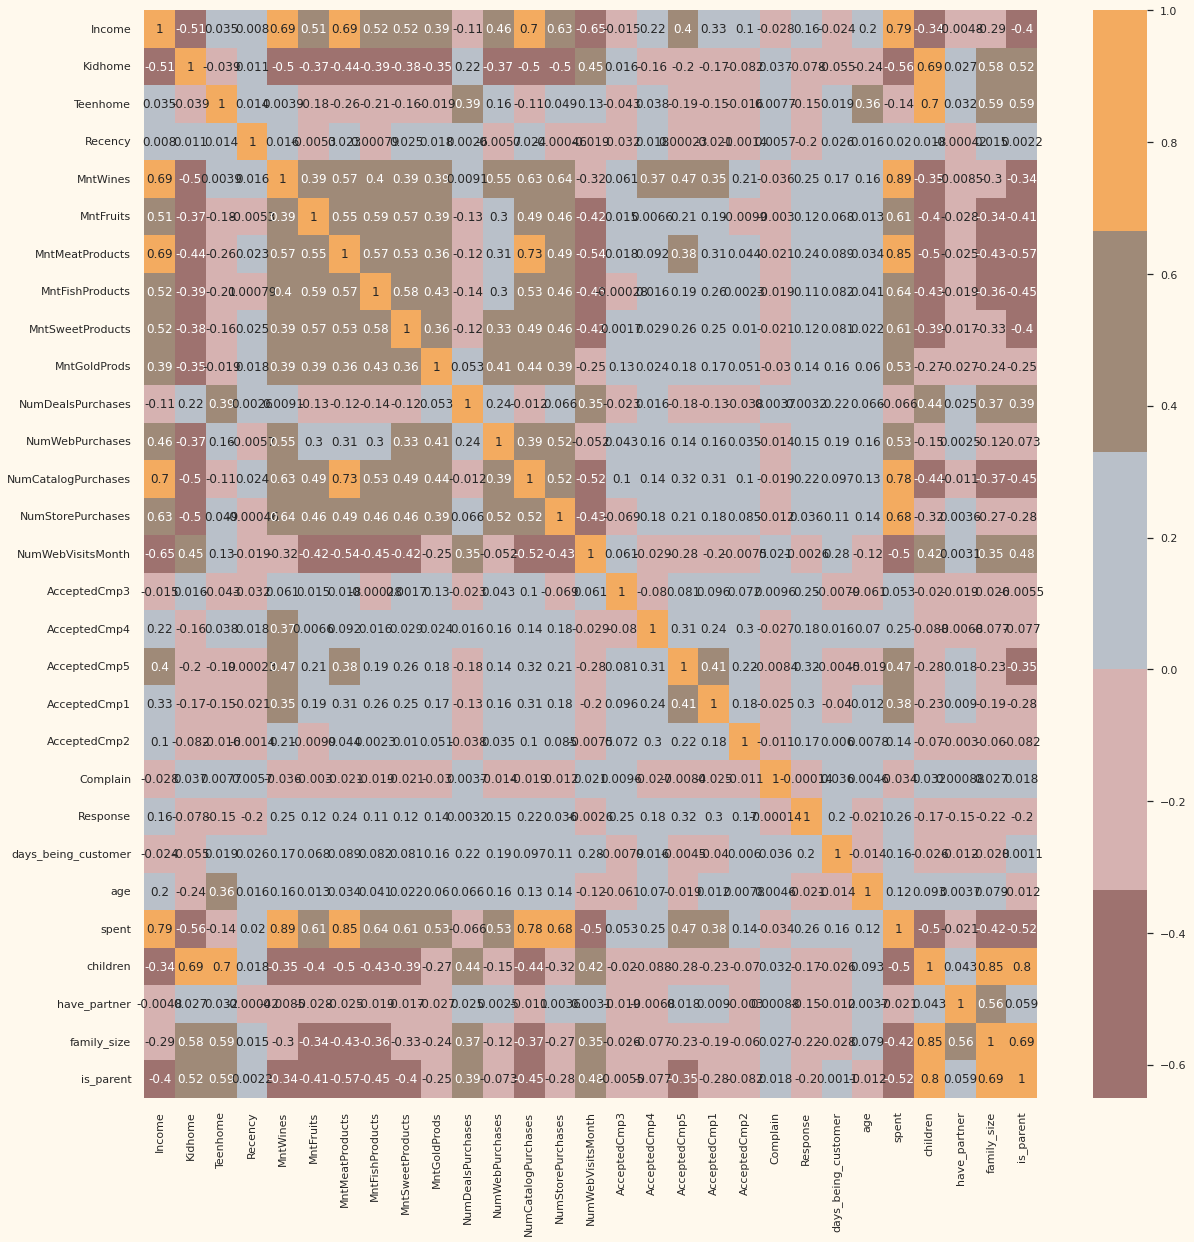

In [158]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_clean.select_dtypes(exclude='object').corr(), annot=True, cmap=cmap, center=0)

## Data Preprocessing

In this step I will preprocess the data to perform clustering operations.
- Label encoding the categorical features
- Scaling the features using the standard scaler

In [159]:
categorical = (df_clean.dtypes == 'object')
object_cols = list(categorical[categorical].index)

print(f'Categorical variables: {object_cols}')

Categorical variables: ['Education']


In [160]:
le = LabelEncoder()
for col in object_cols:
    df_clean[col] = df_clean[[col]].apply(le.fit_transform)
print('All values are now numerical')

All values are now numerical


In [161]:
df = df_clean.copy()

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df = df.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)
print('All features are now scaled')

All features are now scaled


## Dimensionality Reduction

This set contains a lot of features. This means, it will be harder to work with it. Many of these features are correlated. This is why performing dimensionality reductionm can help with the result. So, I going to use PCA but at the same time work with the actual scaled dataframe and compare the results.

**Steps in the section**
- Find the optimal amount of components without losing a lot of information
- Drop the components that don't add enough information

### PCA

In [162]:
pca = PCA()
pca_scaled = pca.fit_transform(df_scaled)
print(f'After applying PCA, the amount of components given is {pca_scaled.shape[1]}')

After applying PCA, the amount of components given is 23


In [163]:
var = pca.explained_variance_ratio_
print(f'The variance ratio for each component is {var}')

The variance ratio for each component is [3.60113213e-01 1.26998440e-01 6.59289509e-02 5.72098514e-02
 4.79047613e-02 4.37051217e-02 4.13535897e-02 3.64384786e-02
 3.32708771e-02 2.80407247e-02 2.62435297e-02 2.40377232e-02
 1.95266325e-02 1.84444375e-02 1.70333844e-02 1.50663643e-02
 1.20677535e-02 1.03942835e-02 8.67574245e-03 7.54614025e-03
 2.84074860e-32 6.50546675e-33 4.91659017e-33]


Let's draw a plot to visualize better the variance ratio

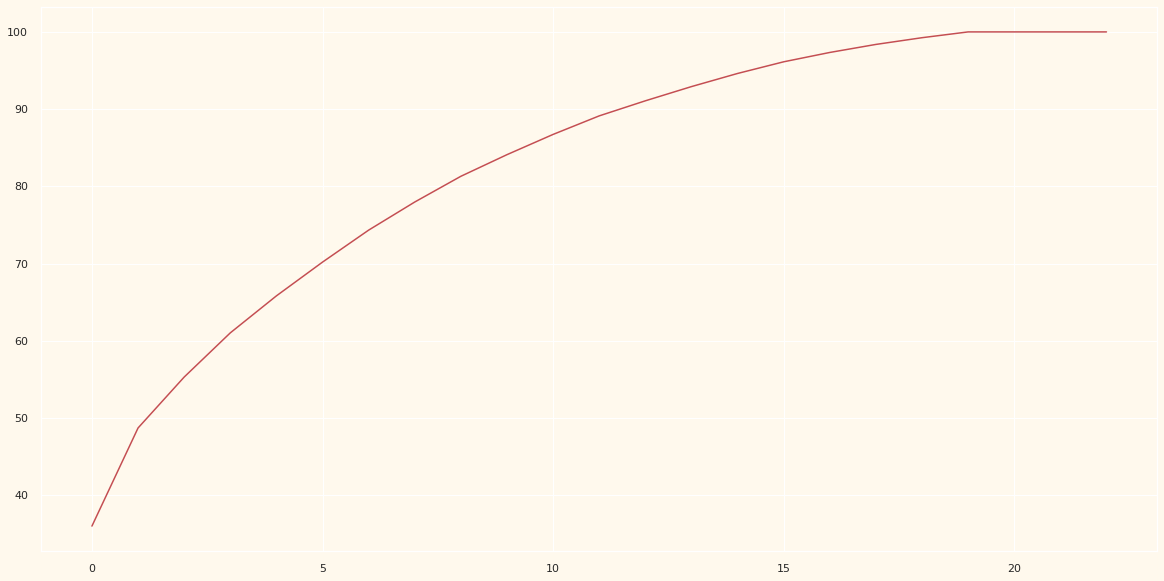

In [164]:
acc_var = np.cumsum(np.round(var, decimals=4)*100)
plt.figure(figsize=(20, 10))
plt.plot(acc_var, 'r-x');

It seems that with eleven components we can preserv 90% of the information, but is still a lot of features. Let's take on the first four for a ~62%

In [165]:
pca_scaled = pd.DataFrame(pca_scaled).drop(np.arange(4, 23), axis=1)
pca_scaled.head()

,0,1,2,3
0,4.986336,-0.161514,2.445404,-0.177913
1,-2.874168,0.022697,-1.530795,-1.401983
2,2.615763,-0.731421,-0.264422,-0.040475
3,-2.654568,-1.455878,-0.398370,1.295816
4,-0.656015,0.177864,-0.141286,1.652892


## Clustering
With the scaled dataset and the reduced dataset, let's perform clustering using K-Means, Agglomerativen Hierarchical and DBSCAN for each one, and compare the silhouette score to pick the best one

**Steps in the clustering**
- Perfom a clustering with K-Means
- Same operation but using Agglomerativen Hierarchical
- Perform another clustering with DBSCAN
- Compare all silhouette scores

### K-Means
#### PCA
Using the Elbow Method we can check which is the best k

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

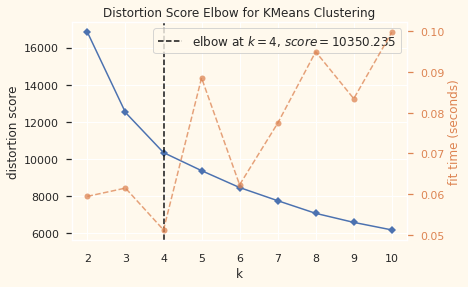

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [166]:
elbow_m = KElbowVisualizer(KMeans(), k = 10)
elbow_m.fit(pca_scaled)
elbow_m.show()

Based in the above cell, four will be an optimal number of clusters for this data. Let's calcule the silhouette score:

In [167]:
km = KMeans(n_clusters=4)
y = km.fit_predict(pca_scaled)
df_clean['k_means_pca'] = y
sil_scores = [['k_means_pca', silhouette_score(pca_scaled, y)]]

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Without PCA

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

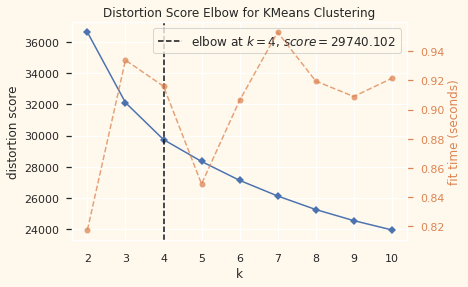

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [168]:
elbow_m = KElbowVisualizer(KMeans(), k=10)
elbow_m.fit(df_scaled)
elbow_m.show()

Same result as with PCA. Number of clusters = 4

In [169]:
km = KMeans(n_clusters=4)
y = km.fit_predict(df_scaled)
df_clean['k_means'] = y
sil_scores.append(['k_means', silhouette_score(df_scaled, y)])

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Agglomerativen Hierarchical
#### PCA

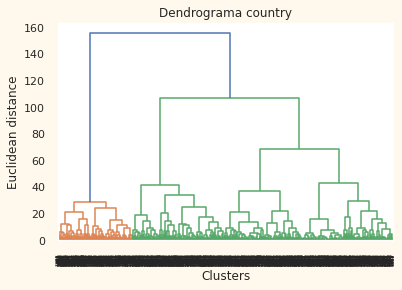

In [170]:
dendrogram_plot = dendrogram(linkage(pca_scaled, method='ward'))
plt.title('Dendrograma country')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distance')
plt.show()

It seems like the numbers of clusters well viewed are: 3 and 4. Let's take 4 for better groupping

In [171]:
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(pca_scaled)
df_scaled['hc_pca'] = y_hc
sil_scores.append(['hc_pca', silhouette_score(pca_scaled, y_hc)])

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


#### Without PCA

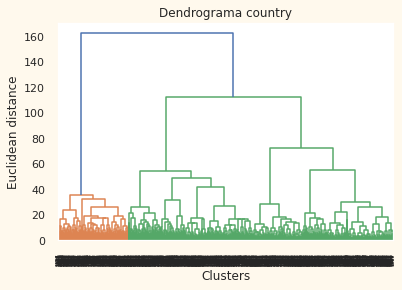

In [172]:
dendrogram_plot = dendrogram(linkage(df_scaled, method='ward'))
plt.title('Dendrograma country')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distance')
plt.show()

Here the amount of clusters is more clearly to be 4

In [173]:
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(pca_scaled)
df_scaled['hc'] = y_hc
sil_scores.append(['hc', silhouette_score(df_scaled, y_hc)])

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


### DBSCAN
#### PCA

In [174]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(pca_scaled)
distances, axes = neighbors_fit.kneighbors(pca_scaled)

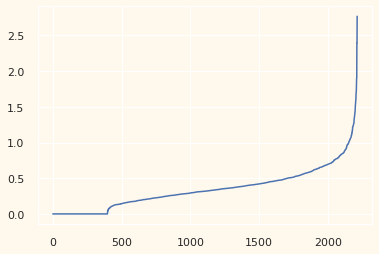

In [175]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

In [176]:
epsilon_values = np.arange(0.2, 1, 0.1)
min_samples = np.arange(2, 12)

In [177]:
dbscan_params = list(product(epsilon_values, min_samples))
n_clusters = []
sil_score = []
for p in dbscan_params:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(pca_scaled)
    try:
        sil_score.append(silhouette_score(pca_scaled, y_dbscan))
    except:
        sil_score.append(0)
    n_clusters.append(len(np.unique(y_dbscan)))

In [178]:
df_param_tunning = pd.DataFrame.from_records(dbscan_params, columns=['epsilon','min_samples'])
df_param_tunning['sil_score'] = sil_score
df_param_tunning['n_clusters'] = n_clusters

In [179]:
pivot_1 = pd.pivot_table(df_param_tunning, values='sil_score', columns='epsilon', index='min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='n_clusters', columns='epsilon', index='min_samples')

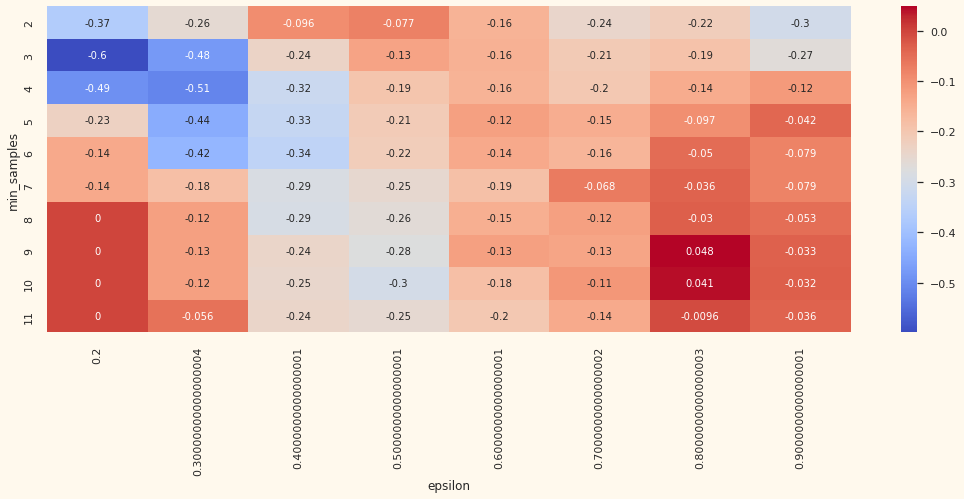

In [180]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

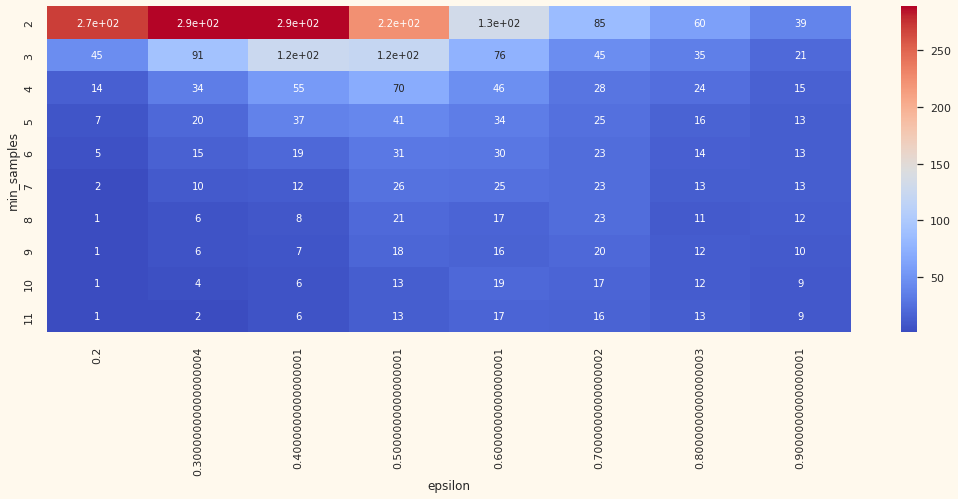

In [181]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

There is no positive silhouette score, so I will skip this section.

#### Without PCA

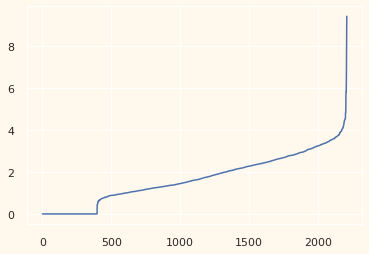

In [182]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_scaled)
distances, axes = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

In [183]:
epsilon_values = np.arange(1, 4, 0.1)
min_samples = np.arange(2, 12)

In [184]:
dbscan_params = list(product(epsilon_values, min_samples))
n_clusters = []
sil_score = []
for p in dbscan_params:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(df_scaled)
    try:
        sil_score.append(silhouette_score(df_scaled, y_dbscan))
    except:
        sil_score.append(0)
    n_clusters.append(len(np.unique(y_dbscan)))

In [185]:
df_param_tunning = pd.DataFrame.from_records(dbscan_params, columns=['epsilon','min_samples'])
df_param_tunning['sil_score'] = sil_score
df_param_tunning['n_clusters'] = n_clusters

pivot_1 = pd.pivot_table(df_param_tunning, values='sil_score', columns='epsilon', index='min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='n_clusters', columns='epsilon', index='min_samples')

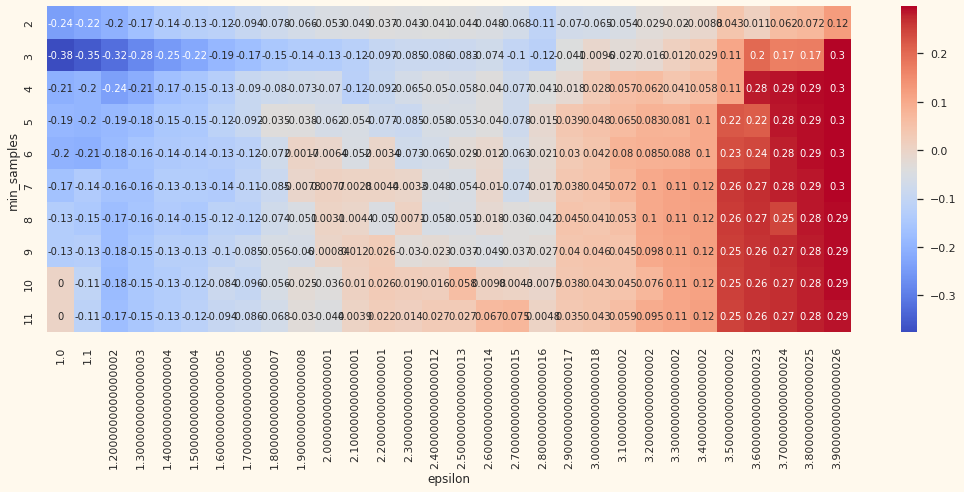

In [186]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

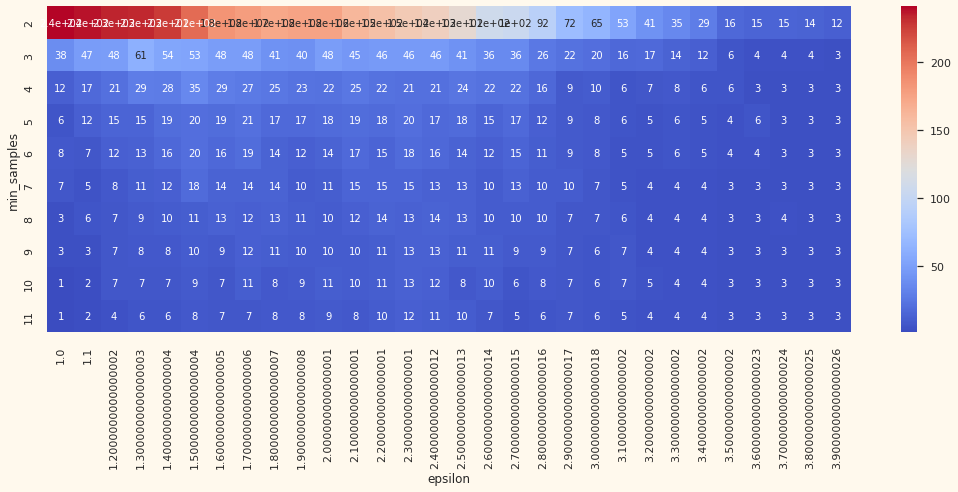

In [187]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

In [188]:
dbscan_train = DBSCAN(eps=3.4, min_samples=7)
y_dbscan = dbscan_train.fit_predict(df_scaled)
df_scaled['dbscan'] = y_dbscan
sil_scores.append(['dbscan', silhouette_score(df_scaled,y_dbscan )])

In [189]:
pd.DataFrame.from_records(sil_scores)

,0,1
0,k_means_pca,0.319794
1,k_means,0.154812
2,hc_pca,0.303918
3,hc,0.177987
4,dbscan,0.155291


From the table above we can say that `K-Means with PCA` works better. So, let's pick that

## Evaluating Models

As we can check earlier, our dataset doesn't have a target feature. The purpose of this section is to study the patterns in the clusters formed.

**Firstly, let us have a look at the group distribution fo clustring**

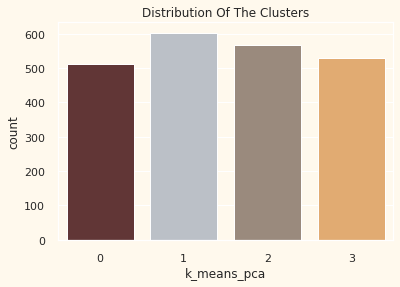

In [190]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df_clean["k_means_pca"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The clusters seems to be fairly distributed

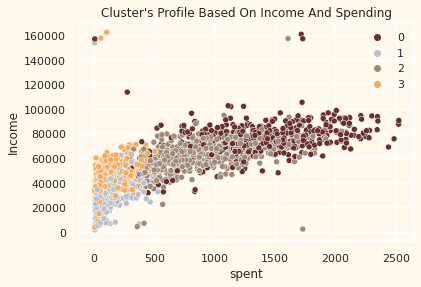

In [191]:
pl = sns.scatterplot(data = df_clean,x=df_clean["spent"], y=df_clean["Income"],hue=df_clean["k_means_pca"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs Spent plot**
- Group 0: High spent and High income
- Group 1: High spent and average income
- Group 2: High spent and average income
- Group 3: Average spent and average income

Let's take a look in the distribution of the amount of products they buy.

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 28.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 79.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 44.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 75.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

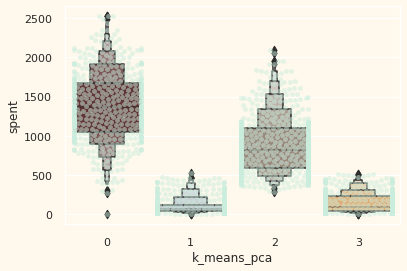

In [192]:
plt.figure()
pl=sns.swarmplot(x=df_clean["k_means_pca"], y=df_clean["spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df_clean["k_means_pca"], y=df_clean["spent"], palette=pal)
plt.show()

From the above plot, it can be seen that cluster 0 contains the biggest spent customers followed by cluster 3.

Let us next explore how did our campaings do in the past.

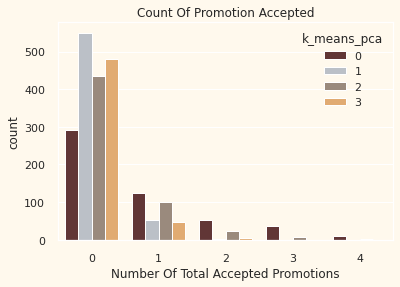

In [193]:
#Creating a feature to get a sum of accepted promotions 
df_clean["total_promos"] = df_clean["AcceptedCmp1"]+ df_clean["AcceptedCmp2"]+ df_clean["AcceptedCmp3"]+ df_clean["AcceptedCmp4"]+ df_clean["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df_clean["total_promos"],hue=df_clean["k_means_pca"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

Not been an overwhelming response to the campaings so far. Very few participants overall.

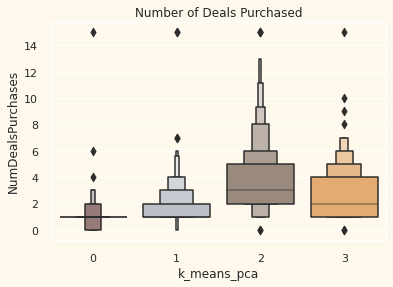

In [194]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_clean["NumDealsPurchases"],x=df_clean["k_means_pca"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Surprisly, the cluster 0 don't purchase a lot of deals. Instead of cluster 3 that buyed multiple deals, followed by cluster 1.

## Profiling

Now that the clusters were formed and the purchasing habits analyzed, let proceed to check who are in the clusters. To check that, I will be ploting some of the features that are indicative of the customer's personal traits.

In [195]:
le.inverse_transform(df_clean.Education)

array(['Graduate', 'Graduate', 'Graduate', ..., 'Graduate',
       'Postgraduate', 'Postgraduate'], dtype=object)

<Figure size 432x288 with 0 Axes>

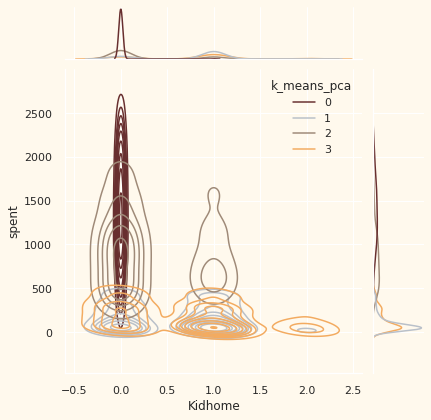

<Figure size 432x288 with 0 Axes>

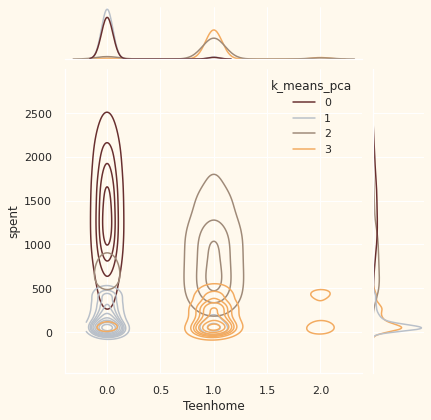

<Figure size 432x288 with 0 Axes>

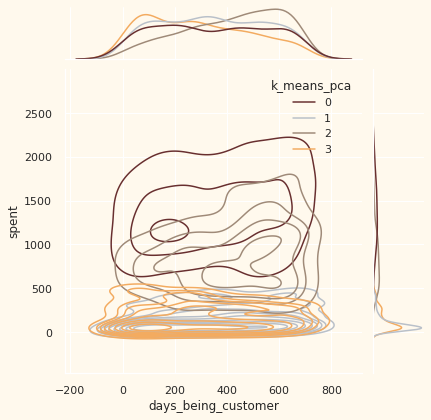

<Figure size 432x288 with 0 Axes>

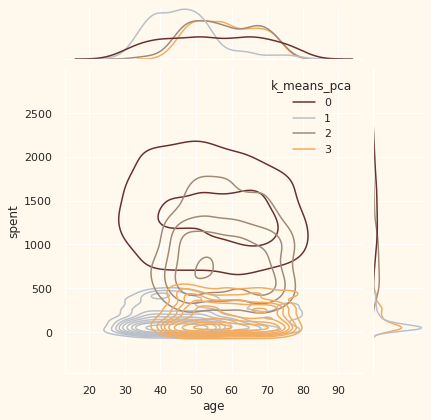

<Figure size 432x288 with 0 Axes>

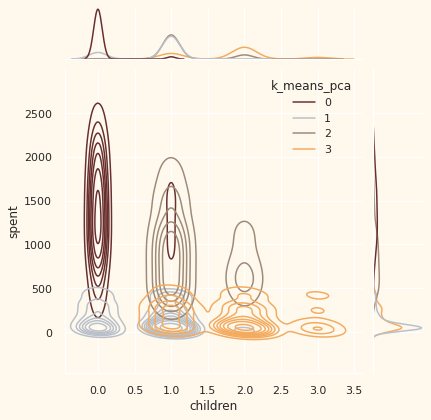

<Figure size 432x288 with 0 Axes>

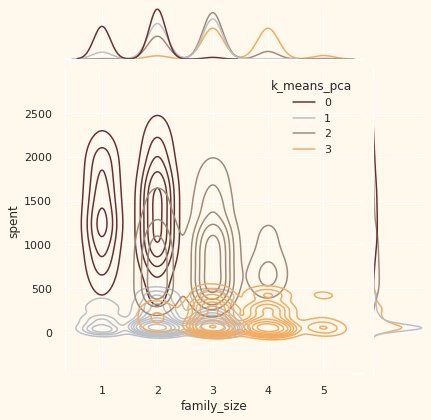

/home/darvand/anaconda3/envs/datascience_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 432x288 with 0 Axes>

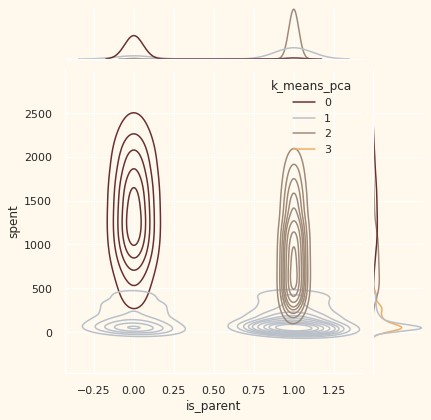

<Figure size 432x288 with 0 Axes>

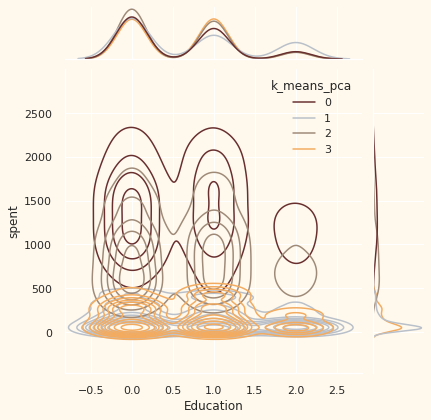

In [196]:
traits = [ "Kidhome","Teenhome","days_being_customer", "age", "children", "family_size", "is_parent", "Education"]

for trait in traits:
    plt.figure()
    sns.jointplot(x=df_clean[trait], y=df_clean["spent"], hue =df_clean["k_means_pca"], kind="kde", palette=pal)
    plt.show()

## Conclusion

- Cluster 0: They are the group that spent more and definitely not a parent. Span all ages. High income group. Most of them are graduated and postgraduate